In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

# Set style for better visualizations
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)  # Set to None for unlimited column width

In [ ]:
# Load datasets with combined topic modeling results from the topic modeling notebook
GB = pd.read_pickle(r"data folder\GB\GB_final_with_topics.pkl")
AT = pd.read_pickle(r"data folder\AT\AT_final_with_topics_combined.pkl")
HR = pd.read_pickle(r"data folder\HR\HR_final_with_topics_combined.pkl")

# Load topic information dataframes with classifications
# gb_topics = pd.read_pickle(r"data folder\GB\GB_topic_info_classified_english.pkl")
# at_en_topics = pd.read_pickle(r"data folder\AT\AT_topic_info_classified_english.pkl")
# at_de_topics = pd.read_pickle(r"data folder\AT\AT_topic_info_classified_german.pkl")
# hr_en_topics = pd.read_pickle(r"data folder\HR\HR_topic_info_classified_english.pkl")
# hr_hr_topics = pd.read_pickle(r"data folder\HR\HR_topic_info_classified_croatian.pkl")

# load true labels 

hr_labels = pd.read_json("data folder/HR/ParlaCAP-test-hr.jsonl", lines=True)
gb_labels = pd.read_json("data folder/GB/ParlaCAP-test-en.jsonl", lines=True) 


# Drop duplicates in HR and GB based on ID
HR = HR.drop_duplicates(subset=['ID'])
GB = GB.drop_duplicates(subset=['ID'])
AT = AT.drop_duplicates(subset=['ID'])

# Perform the merge
HR = HR.merge(hr_labels[['id', 'labels']], how='left', left_on='ID', right_on='id')
HR.rename(columns={'labels': 'True_label'}, inplace=True)
HR.drop(columns=['id'], inplace=True)

GB = GB.merge(gb_labels[['id', 'labels']], how='left', left_on='ID', right_on='id')
GB.rename(columns={'labels': 'True_label'}, inplace=True)
GB.drop(columns=['id'], inplace=True)


# Load the hdbscan dataframes
GB_hdbscan = pd.read_pickle(r"data folder\GB\GB_with_topics_hdbscan.pkl")
AT_hdbscan = pd.read_pickle(r"data folder\AT\AT_with_topics_hdbscan.pkl")
HR_hdbscan = pd.read_pickle(r"data folder\HR\HR_with_topics_hdbscan.pkl")

# Append my_topic from GB_hdbscan to GB as my_topic_hdbscan
GB['my_topic_hdbscan'] = GB_hdbscan['my_topic']

# Append my_topic_en and my_topic_native_language from HR_hdbscan to HR with _hdbscan suffix
HR['my_topic_en_hdbscan'] = HR_hdbscan['my_topic_en']
HR['my_topic_hr_hdbscan'] = HR_hdbscan['my_topic_native_language']

AT['my_topic_en_hdbscan'] = AT_hdbscan['my_topic_en']
AT['my_topic_de_hdbscan'] = AT_hdbscan['my_topic_native_language']

# Rename columns for consistency
HR.rename(columns={
    'Segment_Category_HR_english': 'my_topic_en_gmm',
    'Segment_Category_HR_croatian': 'my_topic_hr_gmm'
}, inplace=True)

AT.rename(columns={
    'Segment_Category_AT_english': 'my_topic_en_gmm',
    'Segment_Category_AT_german': 'my_topic_de_gmm'
}, inplace=True)

GB.rename(columns={
    'Segment_Category_GB_english': 'my_topic_gmm'
}, inplace=True)

# HR: Determine topic consensus
def determine_topic_consensus_hr(row):
    topics = [
        row['my_topic_en_gmm'],
        row['my_topic_hr_gmm'],
        row['my_topic_en_hdbscan'],
        row['my_topic_hr_hdbscan']
    ]
    topics = [topic for topic in topics if topic != 'Other']  # Exclude "Other" from consideration

    if row['Speaker_role'] == 'Chairperson':
        # Chairperson: Only keep non-"Other" if all 4 columns agree
        if len(set(topics)) == 1 and len(topics) == 4:
            return topics[0]
        return 'Other'
    else:
        # Non-chairperson: Determine majority topic
        topic_counts = pd.Series(topics).value_counts()
        if len(topic_counts) == 0:
            return 'Other'  # Default to "Other" if no valid topics
        if topic_counts.iloc[0] > 1:  # Majority exists
            return topic_counts.idxmax()
        if len(topic_counts) > 1 and topic_counts.iloc[0] == topic_counts.iloc[1]:
            return 'Mix'  # Tie between topics
        return topic_counts.idxmax()  # Single most common topic

HR['topic_consensus'] = HR.apply(determine_topic_consensus_hr, axis=1)

# AT: Determine topic consensus
def determine_topic_consensus_at(row):
    topics = [
        row['my_topic_en_gmm'],
        row['my_topic_de_gmm'],
        row['my_topic_en_hdbscan'],
        row['my_topic_de_hdbscan']
    ]
    topics = [topic for topic in topics if topic != 'Other']  # Exclude "Other" from consideration

    if row['Speaker_role'] == 'Chairperson':
        # Chairperson: Only keep non-"Other" if all 4 columns agree
        if len(set(topics)) == 1 and len(topics) == 4:
            return topics[0]
        return 'Other'
    else:
        # Non-chairperson: Determine majority topic
        topic_counts = pd.Series(topics).value_counts()
        if len(topic_counts) == 0:
            return 'Other'  # Default to "Other" if no valid topics
        if topic_counts.iloc[0] > 1:  # Majority exists
            return topic_counts.idxmax()
        if len(topic_counts) > 1 and topic_counts.iloc[0] == topic_counts.iloc[1]:
            return 'Mix'  # Tie between topics
        return topic_counts.idxmax()  # Single most common topic

AT['topic_consensus'] = AT.apply(determine_topic_consensus_at, axis=1)

# GB: Determine topic consensus
def determine_topic_consensus_gb(row):
    topics = [row['my_topic_gmm'], row['my_topic_hdbscan']]
    topics = [topic for topic in topics if topic != 'Other']  # Exclude "Other" from consideration

    if row['Speaker_role'] == 'Chairperson':
        # Chairperson: Use the topic if both columns agree
        if len(set(topics)) == 1 and len(topics) > 0:
            return topics[0]
        return 'Other'
    else:
        # Non-chairperson: Prioritize agreement between columns
        if len(set(topics)) == 1 and len(topics) > 0:
            return topics[0]  # Both columns agree
        if len(set(topics)) > 1:
            return 'Mix'  # Columns differ
        return 'Other'  # No valid topics

GB['topic_consensus'] = GB.apply(determine_topic_consensus_gb, axis=1)

HR_only_true = HR.dropna(subset=['True_label'])

GB_only_true = GB.dropna(subset=['True_label'])

# shapes
AT.shape, HR.shape, GB.shape

((231759, 38), (504338, 39), (670912, 34))

In [ ]:
# example of sequence power

#GB.loc[91:100, ['Text', 'Topic', 'topic_consensus', 'Speaker_role', 'my_topic_gmm','my_topic_hdbscan']]

,Text,Topic,topic_consensus,Speaker_role,my_topic_gmm,my_topic_hdbscan
91,"Given these discussions, why have the French authorities set up a Sangatte 2 camp in Calais? What effect does the Minister think that will have on the situation?",International Affairs,Law and Crime,Regular,Law and Crime,Law and Crime
92,"The French Government will clearly make their own determinations and responses on matters relating to what happens on French soil. Our focus is on security at the juxtaposed controls and on combating organised crime, on which we have good joint working with the French and other Governments. It is clear that we should not establish measures that may act as some sort of magnet and may make the problem worse.",Mix,Law and Crime,Regular,Law and Crime,Law and Crime
93,12. What plans her Department has to regionalise police forces in England and Wales.,Law and Crime,Law and Crime,Regular,Law and Crime,Law and Crime
94,The Government have no plans to move away from the localism that local police forces give us. Localism is something for which the hon. Gentleman campaigned for many years.,Law and Crime,Law and Crime,Regular,Law and Crime,Law and Crime
95,"Does the Minister recognise that although there may be advantages to be gained by regionalisation, such as economies of scale, larger police forces could mean a greater distance between the public and the police and less local accountability?",Law and Crime,Law and Crime,Regular,Law and Crime,Law and Crime
96,"I am slightly confused, because the hon. Gentleman campaigned for the introduction of police and crime commissioners when he was a Conservative Member and sat on the Government Benches. Is he now saying that they should not be there? Perhaps it is just a UKIP policy: one day one thing, and the next day another. At the end of the day, local democracy means that local authorities can make decisions. If they want to amalgamate, they can submit a business plan to us. Manchester has done that, but it is the only one.",Law and Crime,Law and Crime,Regular,Law and Crime,Law and Crime
97,Would not regionalising policing mean either the abolition of PCCs or a multiplication of several times over in the size of their constituencies? Does the Minister agree that either course would be a terrible slap in the face for those who campaigned so hard for so long for the system we now have?,Law and Crime,Law and Crime,Regular,Law and Crime,Law and Crime
98,"There are many present in the Chamber—including, perhaps, one Opposition Member—who have campaigned for localism over many years and who passionately believe in it. PCCs give that to the community and I cannot understand why anybody would change their mind about them.",Government Operations,Law and Crime,Regular,Law and Crime,Law and Crime
99,"Proposals to merge Northamptonshire police with an east midlands police force, as advanced by the Labour party when it was in power, would have been disastrous for Northamptonshire. The present proposals from the police commissioner and the head of the local fire brigade to increasingly merge their operations make lot of sense on so many levels. Will my right hon. Friend encourage this?",Law and Crime,Law and Crime,Regular,Law and Crime,Law and Crime
100,"Not only will I encourage it, but I have seen it going on around the country. Taxpayers’ money needs to be spent efficiently and it must be done in a way that is right for the emergency services. I have seen that happen, and if it happens in my hon. Friend’s constituency then so be it, but it will be a local decision.",Mix,Law and Crime,Regular,Law and Crime,Law and Crime


In [96]:
print(f"In full HR dataset when speaker isn't Chairperson % of parlaCAP model predictions 'Other' topic is: {100 * len(HR[(HR['Speaker_role'] != 'Chairperson') & (HR['Topic'] == 'Other')]) / len(HR[HR['Speaker_role'] != 'Chairperson']):.2f}%")
print(f"In full HR dataset when speaker isn't Chairperson % of my predictions 'Other' topic is: {100 * len(HR[(HR['Speaker_role'] != 'Chairperson') & (HR['topic_consensus'] == 'Other')]) / len(HR[HR['Speaker_role'] != 'Chairperson']):.2f}%")
print(f"In test HR dataset when speaker isn't Chairperson % of true label 'Other' topic is: {100 * len(HR_only_true[(HR_only_true['Speaker_role'] != 'Chairperson') & (HR_only_true['True_label'] == 'Other')]) / len(HR_only_true[HR_only_true['Speaker_role'] != 'Chairperson']):.2f}%")
print('##########################################')

print(f"In full GB dataset when speaker isn't Chairperson % of parlaCAP model predictions 'Other' topic is: {100 * len(GB[(GB['Speaker_role'] != 'Chairperson') & (GB['Topic'] == 'Other')]) / len(GB[GB['Speaker_role'] != 'Chairperson']):.2f}%")
print(f"In full GB dataset when speaker isn't Chairperson % of my predictions 'Other' topic is: {100 * len(GB[(GB['Speaker_role'] != 'Chairperson') & (GB['topic_consensus'] == 'Other')]) / len(GB[GB['Speaker_role'] != 'Chairperson']):.2f}%")
print(f"In test GB dataset when speaker isn't Chairperson % of true label 'Other' topic is: {100 * len(GB_only_true[(GB_only_true['Speaker_role'] != 'Chairperson') & (GB_only_true['True_label'] == 'Other')]) / len(GB_only_true[GB_only_true['Speaker_role'] != 'Chairperson']):.2f}%")

In full HR dataset when speaker isn't Chairperson % of parlaCAP model predictions 'Other' topic is: 13.84%
In full HR dataset when speaker isn't Chairperson % of my predictions 'Other' topic is: 2.85%
In test HR dataset when speaker isn't Chairperson % of true label 'Other' topic is: 5.87%
##########################################
In full HR dataset when speaker isn't Chairperson % of my predictions 'Other' topic is: 2.85%
In test HR dataset when speaker isn't Chairperson % of true label 'Other' topic is: 5.87%
##########################################
In full GB dataset when speaker isn't Chairperson % of parlaCAP model predictions 'Other' topic is: 12.54%
In full GB dataset when speaker isn't Chairperson % of parlaCAP model predictions 'Other' topic is: 12.54%
In full GB dataset when speaker isn't Chairperson % of my predictions 'Other' topic is: 5.44%
In test GB dataset when speaker isn't Chairperson % of true label 'Other' topic is: 5.20%
In full GB dataset when speaker isn't Cha

In [99]:
print(f"In full HR dataset when speaker is Chairperson % of parlaCAP model predictions 'Other' topic is: {100 * len(HR[(HR['Speaker_role'] == 'Chairperson') & (HR['Topic'] == 'Other')]) / len(HR[HR['Speaker_role'] == 'Chairperson']):.2f}%")
print(f"In full HR dataset when speaker is Chairperson % of my predictions 'Other' topic is: {100 * len(HR[(HR['Speaker_role'] == 'Chairperson') & (HR['topic_consensus'] == 'Other')]) / len(HR[HR['Speaker_role'] == 'Chairperson']):.2f}%")
print(f"In test HR dataset when speaker is Chairperson % of true label 'Other' topic is: {100 * len(HR_only_true[(HR_only_true['Speaker_role'] == 'Chairperson') & (HR_only_true['True_label'] == 'Other')]) / len(HR_only_true[HR_only_true['Speaker_role'] == 'Chairperson']):.2f}%")
print('##########################################')

print(f"In full GB dataset when speaker is Chairperson % of parlaCAP model predictions 'Other' topic is: {100 * len(GB[(GB['Speaker_role'] == 'Chairperson') & (GB['Topic'] == 'Other')]) / len(GB[GB['Speaker_role'] == 'Chairperson']):.2f}%")
print(f"In full GB dataset when speaker is Chairperson % of my predictions 'Other' topic is: {100 * len(GB[(GB['Speaker_role'] == 'Chairperson') & (GB['topic_consensus'] == 'Other')]) / len(GB[GB['Speaker_role'] == 'Chairperson']):.2f}%")
print(f"In test GB dataset when speaker is Chairperson % of true label 'Other' topic is: {100 * len(GB_only_true[(GB_only_true['Speaker_role'] == 'Chairperson') & (GB_only_true['True_label'] == 'Other')]) / len(GB_only_true[GB_only_true['Speaker_role'] == 'Chairperson']):.2f}%")

In full HR dataset when speaker is Chairperson % of parlaCAP model predictions 'Other' topic is: 93.07%
In full HR dataset when speaker is Chairperson % of my predictions 'Other' topic is: 75.51%
In test HR dataset when speaker is Chairperson % of true label 'Other' topic is: 19.61%
##########################################
In full GB dataset when speaker is Chairperson % of parlaCAP model predictions 'Other' topic is: 86.82%
In full HR dataset when speaker is Chairperson % of my predictions 'Other' topic is: 75.51%
In test HR dataset when speaker is Chairperson % of true label 'Other' topic is: 19.61%
##########################################
In full GB dataset when speaker is Chairperson % of parlaCAP model predictions 'Other' topic is: 86.82%
In full GB dataset when speaker is Chairperson % of my predictions 'Other' topic is: 25.05%
In test GB dataset when speaker is Chairperson % of true label 'Other' topic is: 80.00%
In full GB dataset when speaker is Chairperson % of my predict

In [85]:
# === POLICY-FOCUSED CONFUSION MATRIX (FLEXIBLE SAMPLING) ===

def analyze_labels(df, evaluation_topic_col, true_label_topic_column,
                   sample_size='all', min_word_count=None, max_word_count=None, 
                   exclude_roles=None, exclude_topics=None, 
                   text_column='Text', plot_size=(16, 12), dataset_name="Dataset"):

    if exclude_roles is None:
        exclude_roles = []
    if exclude_topics is None:
        exclude_topics = []

    # Remove invalid rows
    df = df[~df[true_label_topic_column].isin(['-'])]
    df = df.dropna(subset=[evaluation_topic_col, true_label_topic_column])

    # Filter out specified speaker roles
    if exclude_roles:
        df = df[~df['Speaker_role'].isin(exclude_roles)]

    # Remove specified topic labels
    if exclude_topics:
        for col in [evaluation_topic_col, true_label_topic_column]:
            df = df[~df[col].isin(exclude_topics)]

    # Filter rows based on word count
    if min_word_count is not None:
        df = df[df[text_column].apply(lambda x: len(str(x).split())) >= min_word_count]
    if max_word_count is not None:
        df = df[df[text_column].apply(lambda x: len(str(x).split())) <= max_word_count]

    # Flexible sampling per CAP label
    if sample_size != 'all':
        sampled_dfs = []
        for category in df[true_label_topic_column].unique():
            category_df = df[df[true_label_topic_column] == category]
            if len(category_df) >= sample_size:
                sampled_dfs.append(category_df.sample(n=sample_size))
            else:
                sampled_dfs.append(category_df)
        df = pd.concat(sampled_dfs, ignore_index=True)

    # Calculate metrics
    my_topics = df[evaluation_topic_col]
    parlacap_topics = df[true_label_topic_column]
    from sklearn.metrics import f1_score
    f1_weighted = f1_score(parlacap_topics, my_topics, average='weighted', zero_division=0)
    f1_macro = f1_score(parlacap_topics, my_topics, average='macro', zero_division=0)
    f1_micro = f1_score(parlacap_topics, my_topics, average='micro', zero_division=0)
    exact_matches = (my_topics == parlacap_topics).sum()
    accuracy_result = exact_matches / len(df)

    # Create confusion matrix
    plt.figure(figsize=plot_size)
    categories = parlacap_topics.value_counts().index.tolist()
    conf_matrix = confusion_matrix(parlacap_topics, my_topics, labels=categories)
    sns.heatmap(conf_matrix, xticklabels=categories, yticklabels=categories, annot=True, fmt='d',
                cmap='Blues', cbar_kws={'label': 'Count'}, square=True, annot_kws={'size': 8},
                linewidths=0.5, linecolor='white')
    plt.title(f'Confusion Matrix for {dataset_name}, f1 scores: macro={f1_macro:.2f}, micro={f1_micro:.2f}')
    plt.xlabel('Predicted Label')
    plt.ylabel('ParlaCAP Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return {
        'f1_macro': f1_macro,
        'f1_micro': f1_micro,
        'accuracy': accuracy_result,
        'exact_matches': exact_matches,
        'total_speeches': len(df),
        'categories_count': len(categories),
        'sample_size': sample_size,
        'min_word_count': min_word_count,
        'max_word_count': max_word_count,
        'exclude_roles': exclude_roles,
        'exclude_topics': exclude_topics
    }

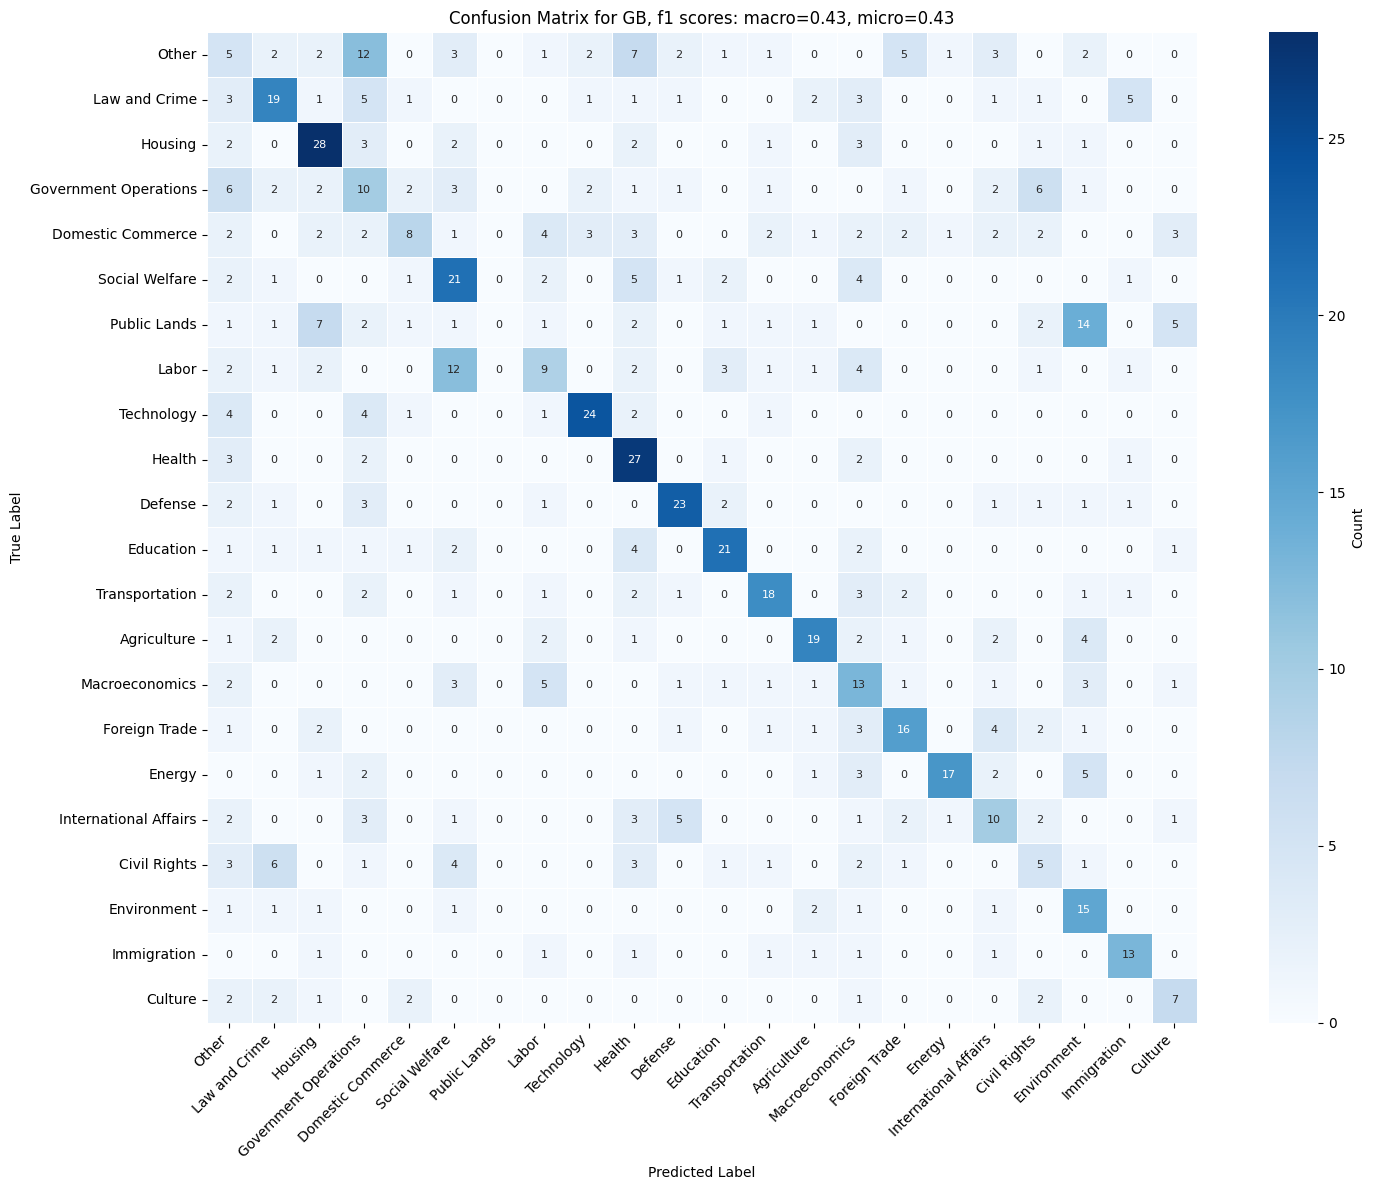

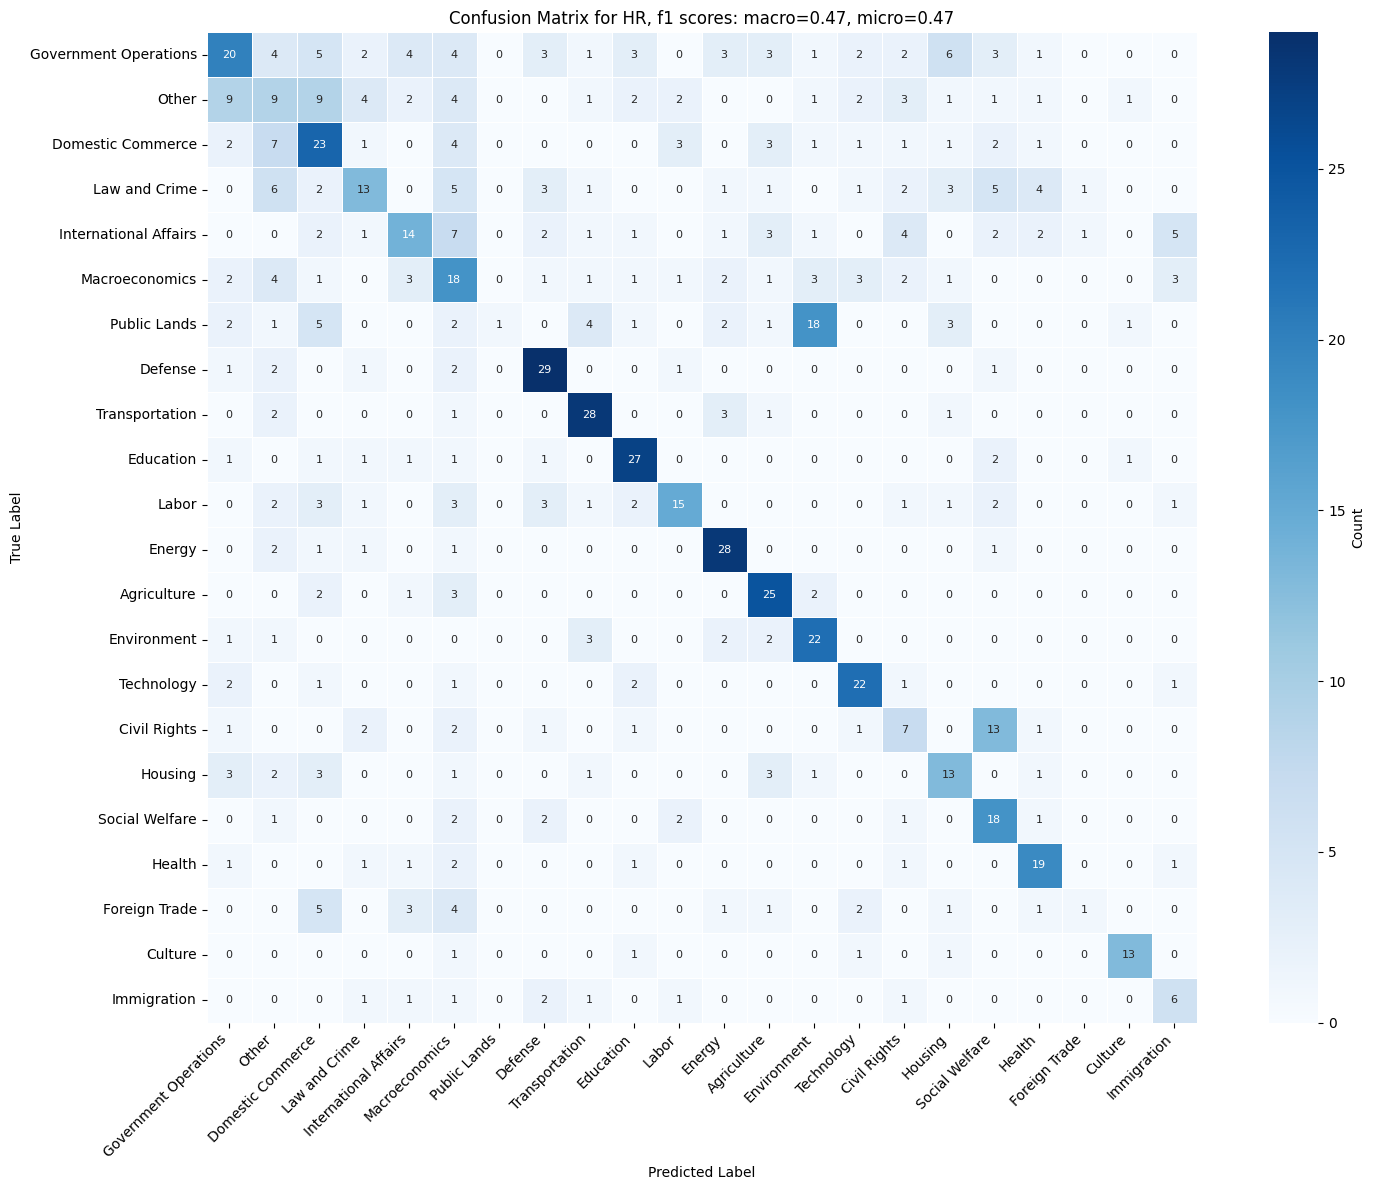

In [73]:
# results compared to human labels

results_all = {}

results_all['GB'] = analyze_labels(
    GB, 'topic_consensus', 'True_label',
    exclude_topics=['Mix'],
    dataset_name="GB"
)

results_all['HR'] = analyze_labels(
    HR, 'topic_consensus', 'True_label',
    exclude_topics=['Mix'],
    dataset_name="HR",
)

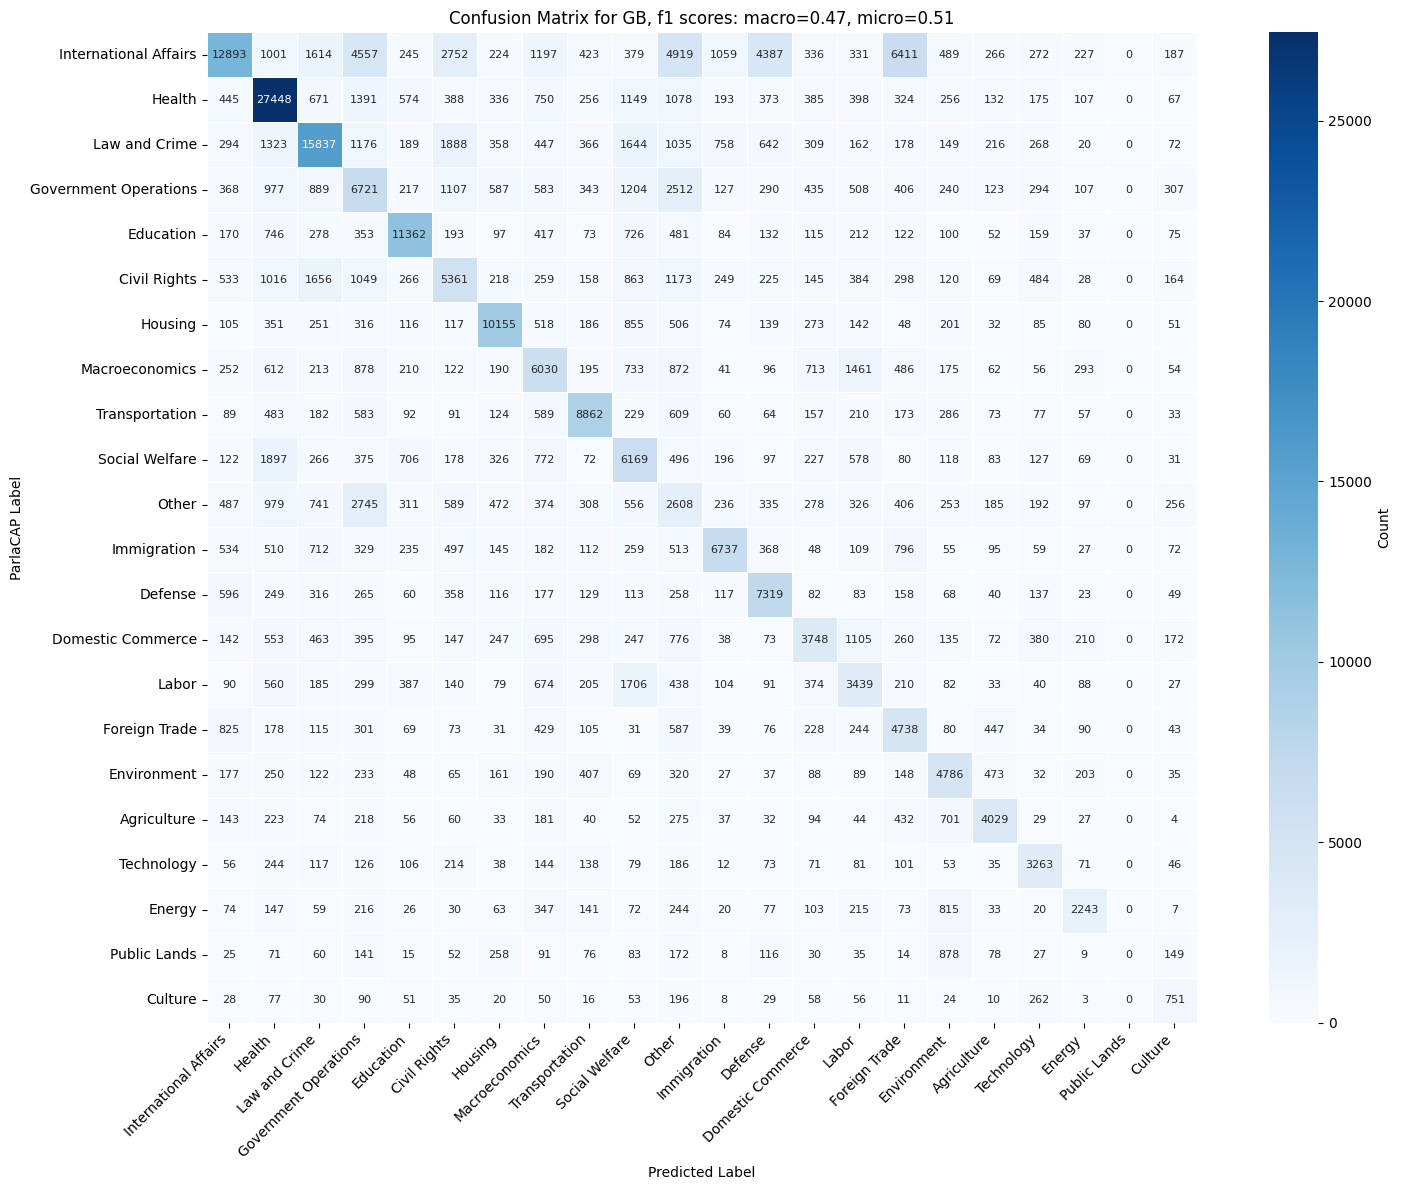

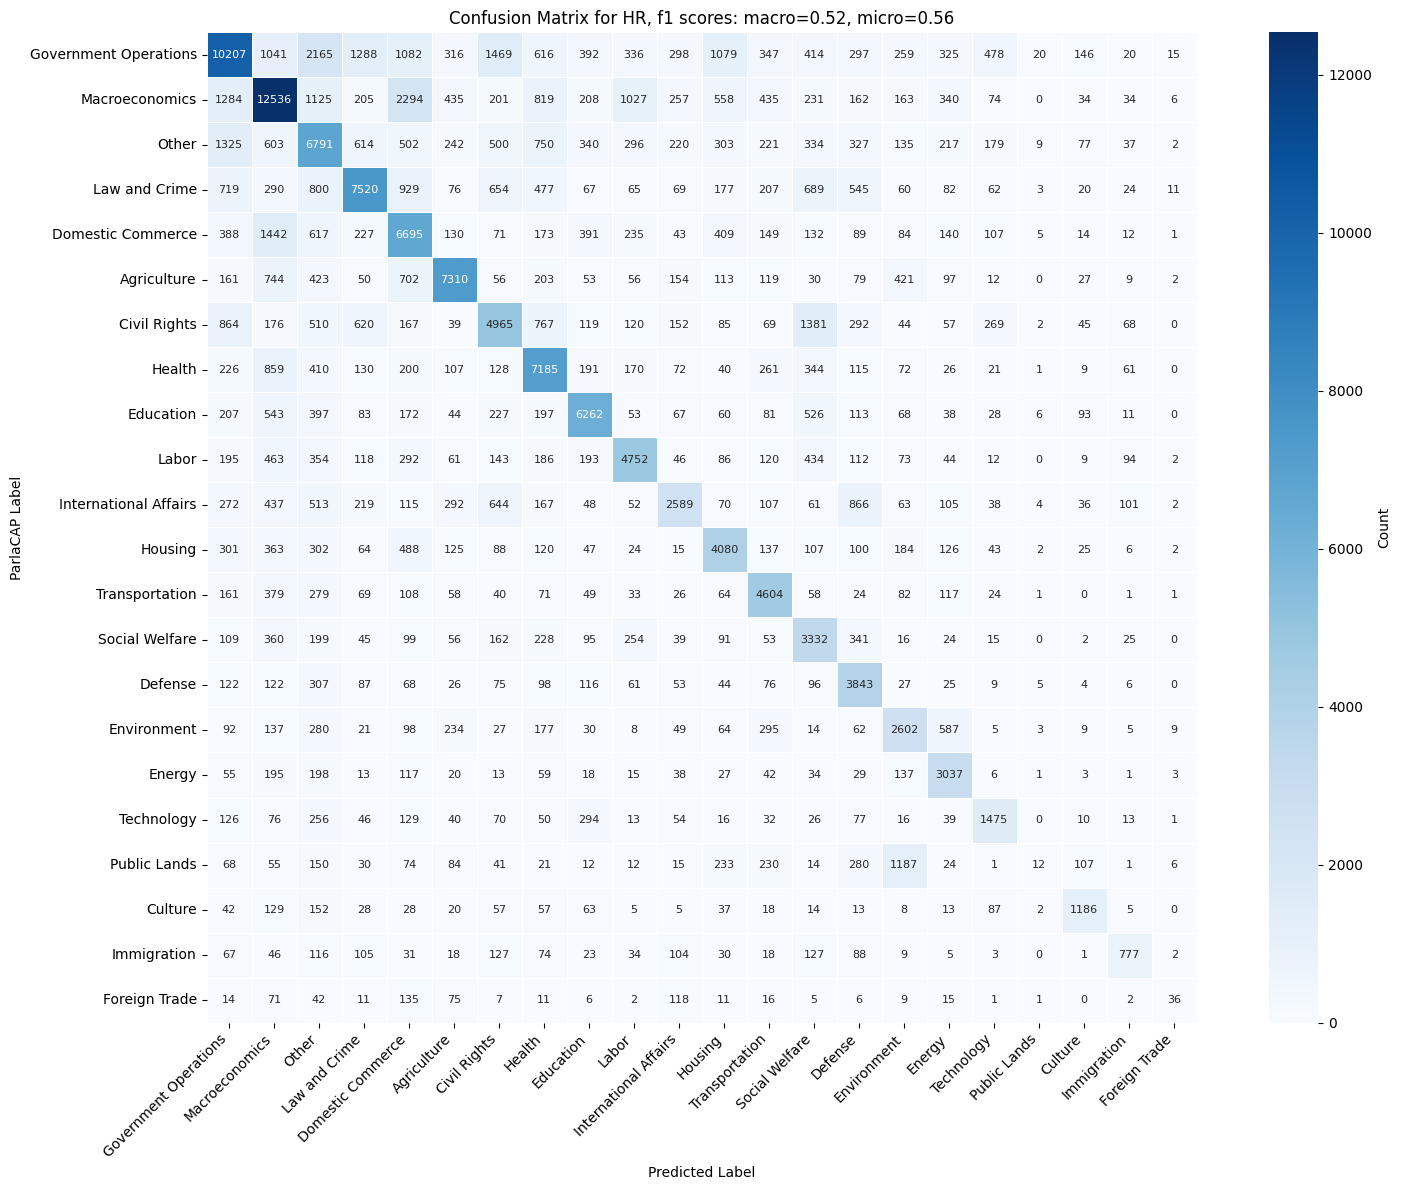

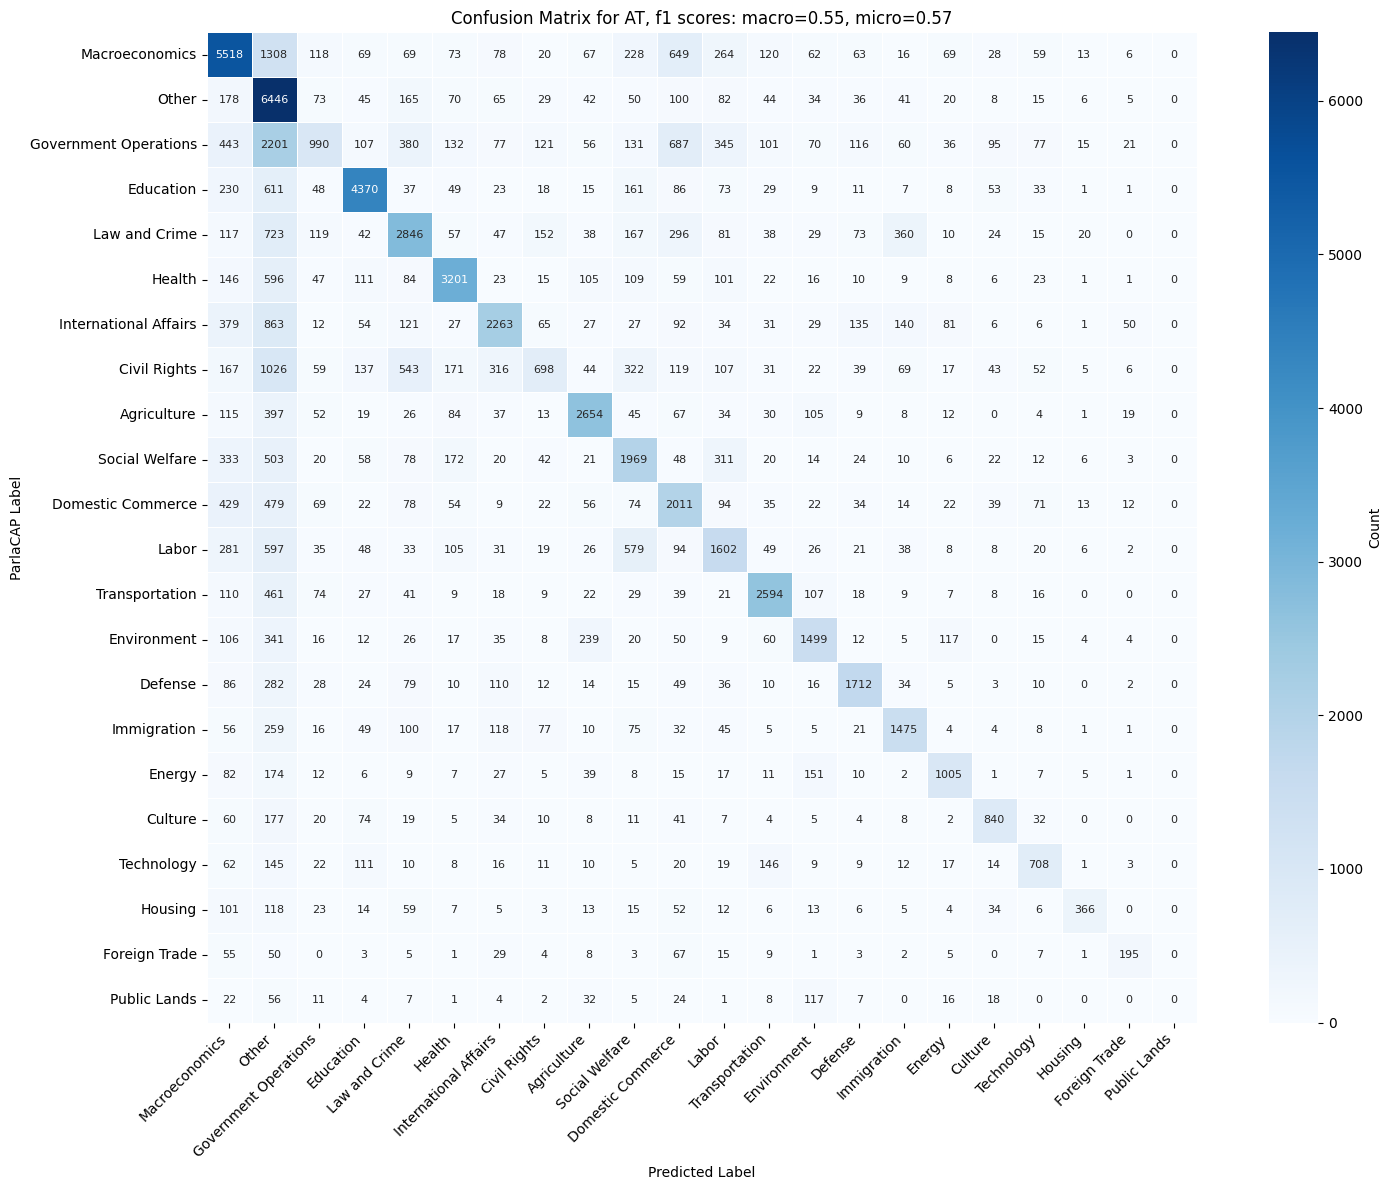

In [106]:
# results compared to parlacap

results_all = {}

results_all['GB'] = analyze_labels(
    GB, 'topic_consensus', 'Topic',
    #exclude_roles=['Chairperson'],
    exclude_topics=['Mix'],
    min_word_count=70,
    dataset_name="GB"
)

results_all['HR'] = analyze_labels(
    HR, 'topic_consensus', 'Topic',
    #exclude_roles=['Chairperson'],
    exclude_topics=['Mix'],
    min_word_count=70,
    dataset_name="HR",
)

results_all['AT'] = analyze_labels(
    AT, 'topic_consensus', 'Topic',
    #exclude_roles=['Chairperson'],
    exclude_topics=['Mix'],
    min_word_count=70,
    dataset_name="AT"
)

In [40]:
# Calculate speech length and filter middle 50%
HR['speech_length'] = HR['Text'].apply(lambda x: len(str(x).split()))
HR_filtered = HR[HR['speech_length'].between(HR['speech_length'].quantile(0.25), HR['speech_length'].quantile(0.75))]

# Filter rows with true labels
HR_only_true = HR.dropna(subset=['True_label'])

# Total rows with true labels
print(f"Total human annotated rows: {HR_only_true.shape[0]}")
print("##########################################")

# Proportion of 'Other' topics
print(f"Percentage of topic 'Other' in entire dataset: {100 * len(HR[HR['Topic'] == 'Other']) / len(HR):.2f}%")
print(f"Percentage of topic 'Other' in filtered dataset (middle 50% of speeches): {100 * len(HR_filtered[HR_filtered['Topic'] == 'Other']) / len(HR_filtered):.2f}%")
print(f"Percentage of topic 'Other' in test dataset: {100 * len(HR_only_true[HR_only_true['Topic'] == 'Other']) / len(HR_only_true):.2f}%")
print("##########################################")

# Proportion of 'Chairperson' role
print(f"Percentage of 'Chairperson' in entire dataset: {100 * len(HR[HR['Speaker_role'] == 'Chairperson']) / len(HR):.2f}%")
print(f"Percentage of 'Chairperson' in filtered dataset (middle 50% of speeches): {100 * len(HR_filtered[HR_filtered['Speaker_role'] == 'Chairperson']) / len(HR_filtered):.2f}%")
print(f"Percentage of 'Chairperson' in test dataset: {100 * len(HR_only_true[HR_only_true['Speaker_role'] == 'Chairperson']) / len(HR_only_true):.2f}%")
print("##########################################")

# Proportion of model 'Other' topics for Chairperson role
print(f"In test dataset when role is Chairperson % of model predictions 'Other' topic is: {100 * len(HR_only_true[(HR_only_true['Speaker_role'] == 'Chairperson') & (HR_only_true['Topic'] == 'Other')]) / len(HR_only_true[HR_only_true['Speaker_role'] == 'Chairperson']):.2f}%")
print(f"In filtered dataset when role is Chairperson % of model predictions 'Other' topic is: {100 * len(HR_filtered[(HR_filtered['Speaker_role'] == 'Chairperson') & (HR_filtered['Topic'] == 'Other')]) / len(HR_filtered[HR_filtered['Speaker_role'] == 'Chairperson']):.2f}%")
print(f"In full dataset when role is Chairperson % of model predictions 'Other' topic is: {100 * len(HR[(HR['Speaker_role'] == 'Chairperson') & (HR['Topic'] == 'Other')]) / len(HR[HR['Speaker_role'] == 'Chairperson']):.2f}%")
print("##########################################")

# Percentage of true label 'Other' topics for Chairperson role
print(f"Percentage of true label 'Other' for 'Chairperson' in test dataset: {100 * len(HR_only_true[(HR_only_true['Speaker_role'] == 'Chairperson') & (HR_only_true['True_label'] == 'Other')]) / len(HR_only_true[HR_only_true['Speaker_role'] == 'Chairperson']):.2f}%")
print(f"Percentage of model predicted label 'Other' for 'Chairperson' in test dataset: {100 * len(HR_only_true[(HR_only_true['Speaker_role'] == 'Chairperson') & (HR_only_true['Topic'] == 'Other')]) / len(HR_only_true[HR_only_true['Speaker_role'] == 'Chairperson']):.2f}%")
print("##########################################")

# Percentage of role when topic is Other in test dataset
print(f"Percentage of 'Chairperson' role when true label is 'Other' in test dataset: {100 * len(HR_only_true[(HR_only_true['True_label'] == 'Other') & (HR_only_true['Speaker_role'] == 'Chairperson')]) / len(HR_only_true[HR_only_true['True_label'] == 'Other']):.2f}%")
print(f"Percentage of 'Chairperson' role when model label is 'Other' in test dataset: {100 * len(HR_filtered[(HR_filtered['Topic'] == 'Other') & (HR_filtered['Speaker_role'] == 'Chairperson')]) / len(HR_filtered[HR_filtered['Topic'] == 'Other']):.2f}%")

Total human annotated rows: 869
##########################################
Percentage of topic 'Other' in entire dataset: 52.58%
Percentage of topic 'Other' in filtered dataset (middle 50% of speeches): 56.96%
Percentage of topic 'Other' in test dataset: 3.45%
##########################################
Percentage of 'Chairperson' in entire dataset: 48.89%
Percentage of 'Chairperson' in filtered dataset (middle 50% of speeches): 53.66%
Percentage of 'Chairperson' in test dataset: 5.87%
##########################################
In test dataset when role is Chairperson % of model predictions 'Other' topic is: 17.65%
In filtered dataset when role is Chairperson % of model predictions 'Other' topic is: 90.10%
In full dataset when role is Chairperson % of model predictions 'Other' topic is: 93.07%
##########################################
Percentage of true label 'Other' for 'Chairperson' in test dataset: 19.61%
Percentage of model predicted label 'Other' for 'Chairperson' in test dataset:

In [104]:
def compare_topic_distributions(df, our_col, parlacap_col, dataset_name):
    """Compare distribution of our topics vs ParlaCAP topics"""
    
    # Remove missing data
    clean_df = df.dropna(subset=[our_col, parlacap_col])
    
    # Get distributions
    our_dist = clean_df[our_col].value_counts(normalize=True) * 100
    parlacap_dist = clean_df[parlacap_col].value_counts(normalize=True) * 100
    
    # Combine into comparison DataFrame
    comparison = pd.DataFrame({
        'Our_Classification': our_dist,
        'Human labels': parlacap_dist
    }).fillna(0)
    
    # Plot comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Side-by-side comparison
    comparison.plot(kind='barh', ax=ax1, width=0.8, alpha=0.8)
    ax1.set_title(f'{dataset_name}: Topic Distribution Comparison')
    ax1.set_xlabel('Percentage (%)')
    ax1.set_ylabel('Topics')
    ax1.legend(title='Source')
    ax1.grid(axis='x', alpha=0.3)
    
    # Difference plot
    diff = comparison['Our_Classification'] - comparison['Human labels']
    colors = ['red' if x < 0 else 'green' for x in diff]
    diff.plot(kind='barh', ax=ax2, color=colors, alpha=0.7)
    ax2.set_title(f'{dataset_name}: Difference (Our - Human labels)')
    ax2.set_xlabel('Percentage Point Difference')
    ax2.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    ax2.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print top differences
    print(f"\n📈 {dataset_name} - Largest Distribution Differences:")
    top_diffs = diff.abs().nlargest(5)
    for topic, abs_diff in top_diffs.items():
        actual_diff = diff[topic]
        direction = "over-represented" if actual_diff > 0 else "under-represented"

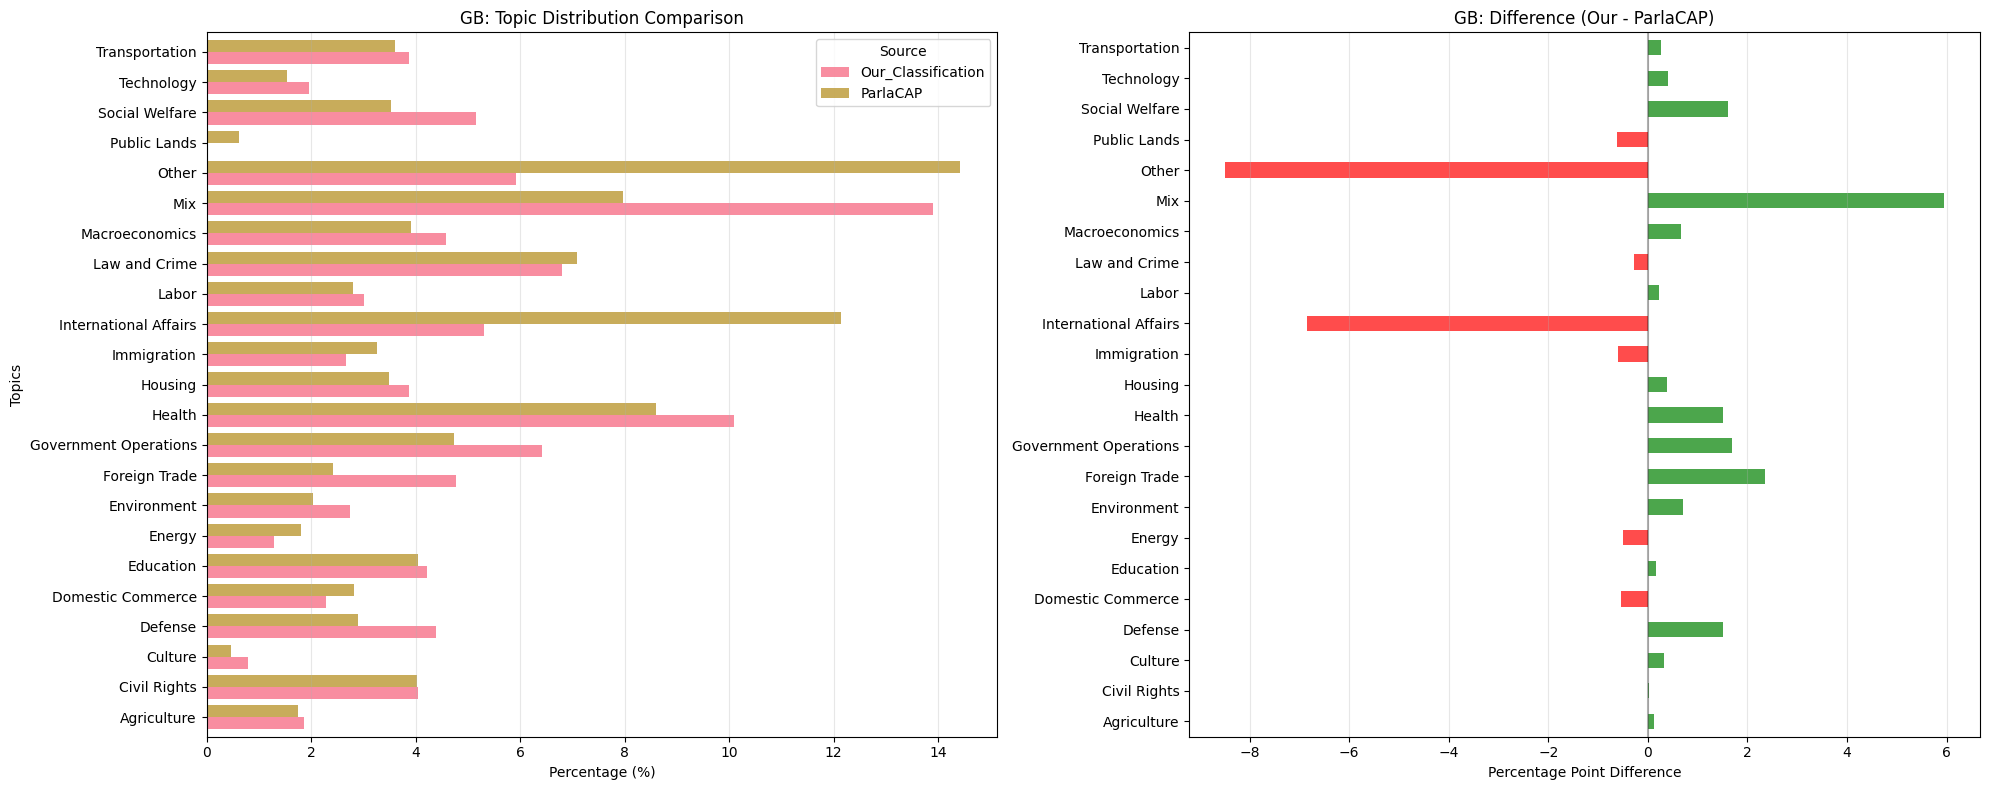


📈 GB - Largest Distribution Differences:


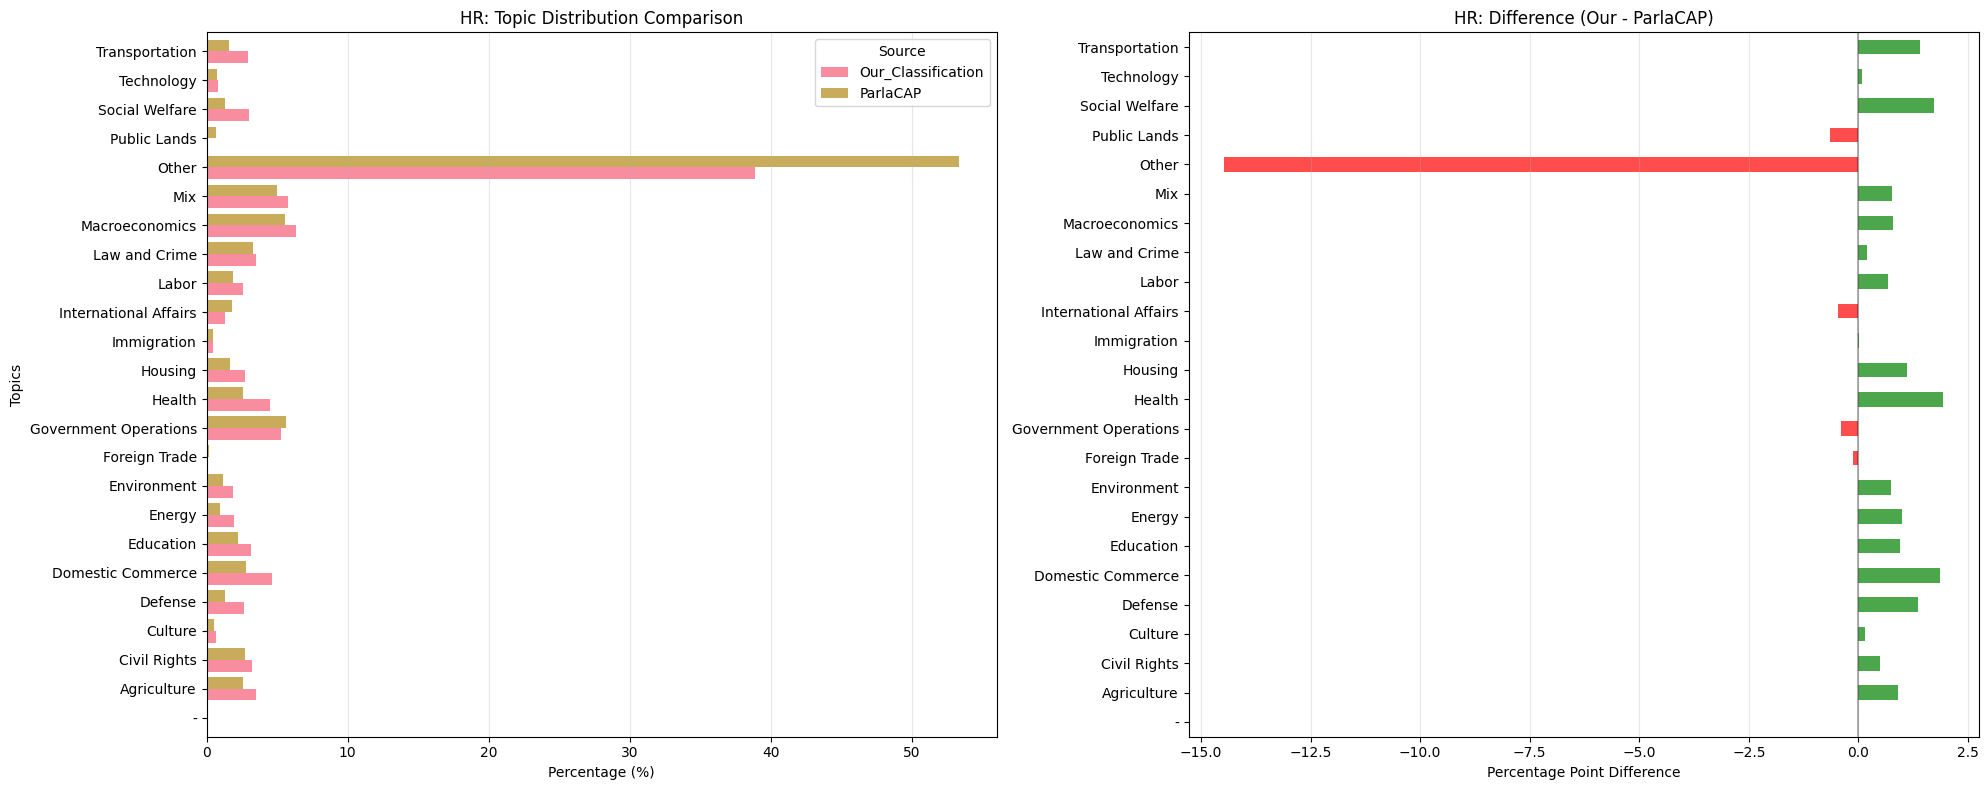


📈 HR - Largest Distribution Differences:


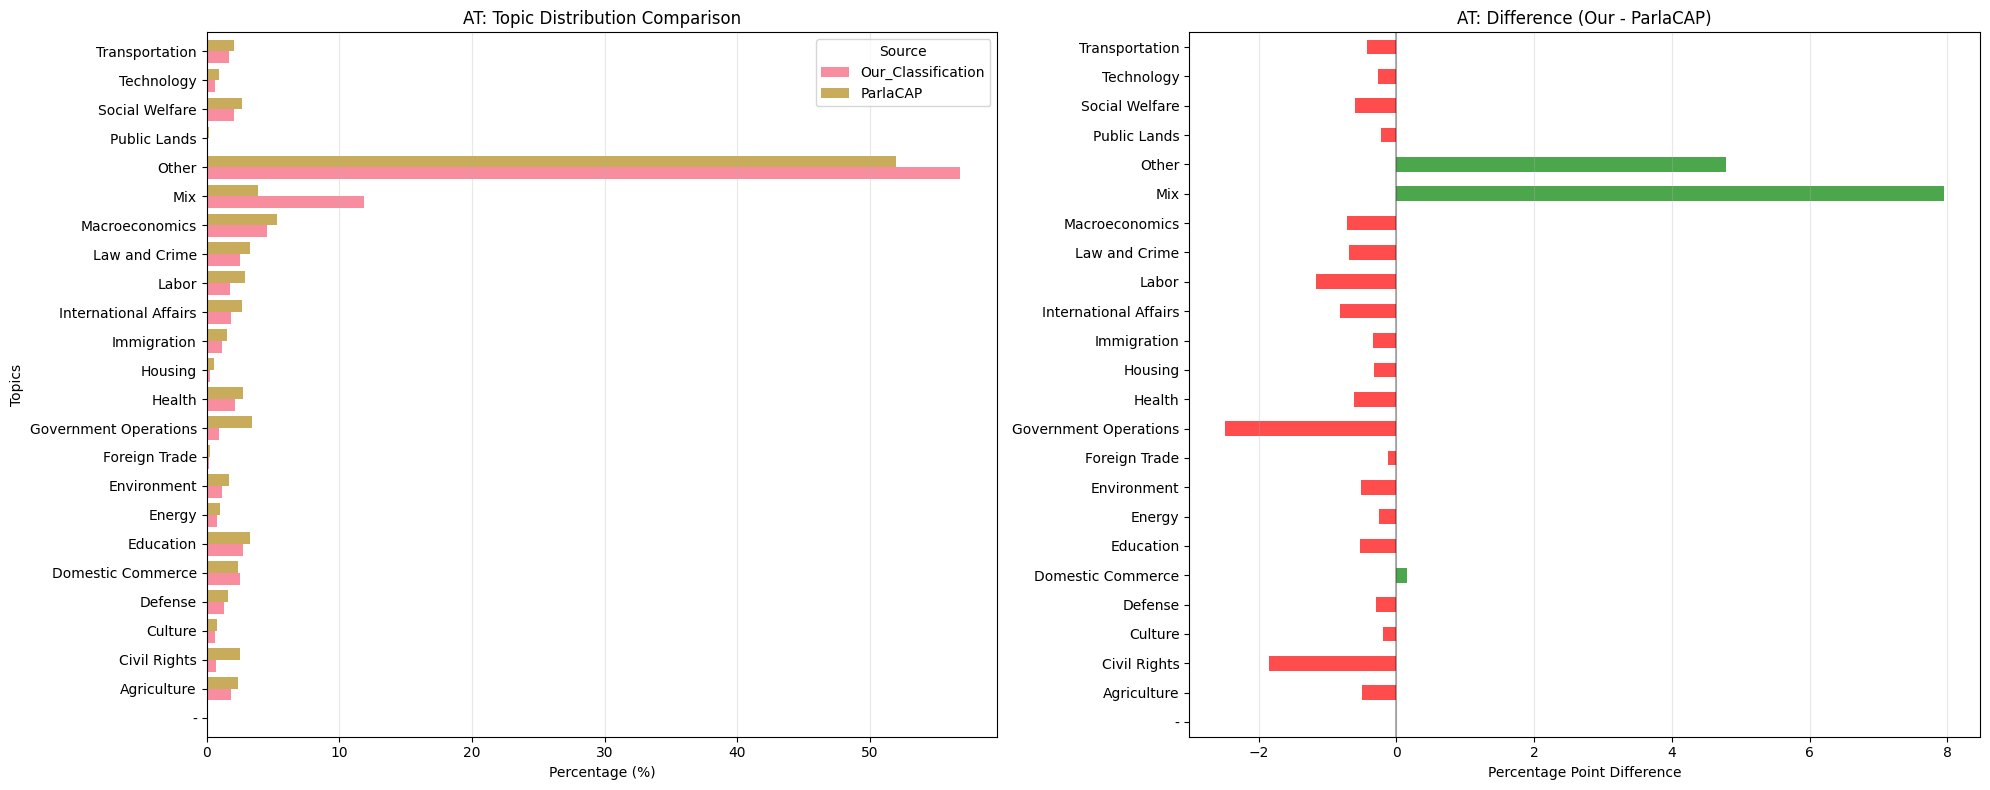


📈 AT - Largest Distribution Differences:


In [102]:
compare_topic_distributions(GB, 'topic_consensus', 'Topic', 'GB')

compare_topic_distributions(HR, 'topic_consensus', 'Topic', 'HR')

compare_topic_distributions(AT, 'topic_consensus', 'Topic', 'AT')


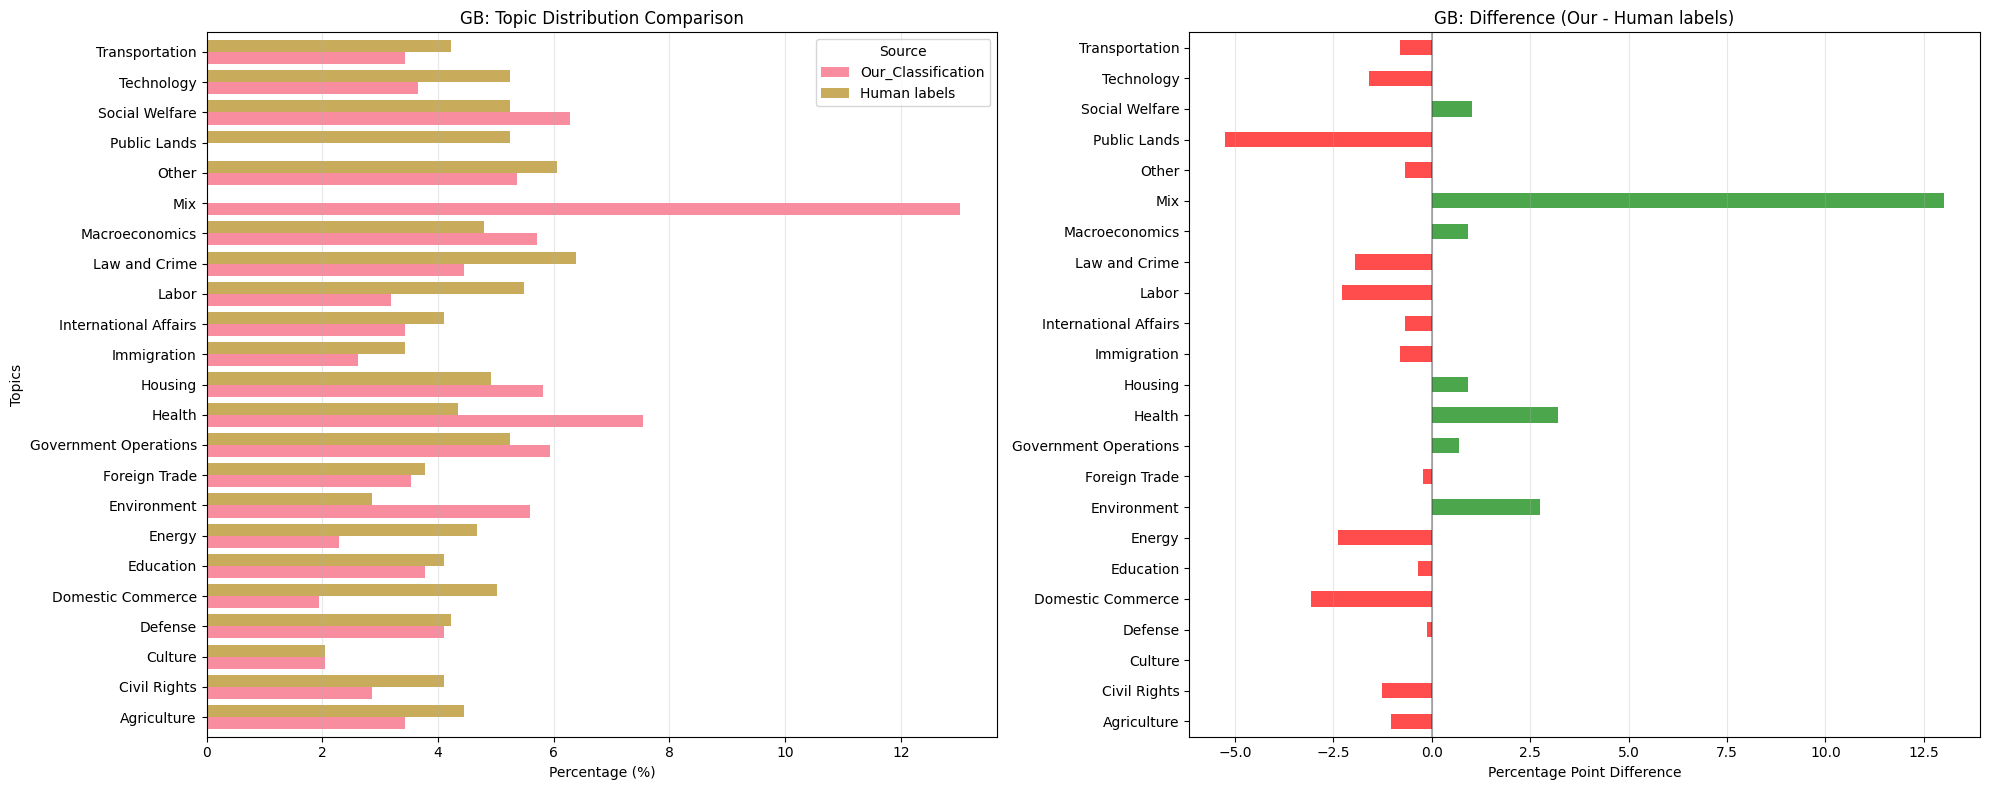


📈 GB - Largest Distribution Differences:


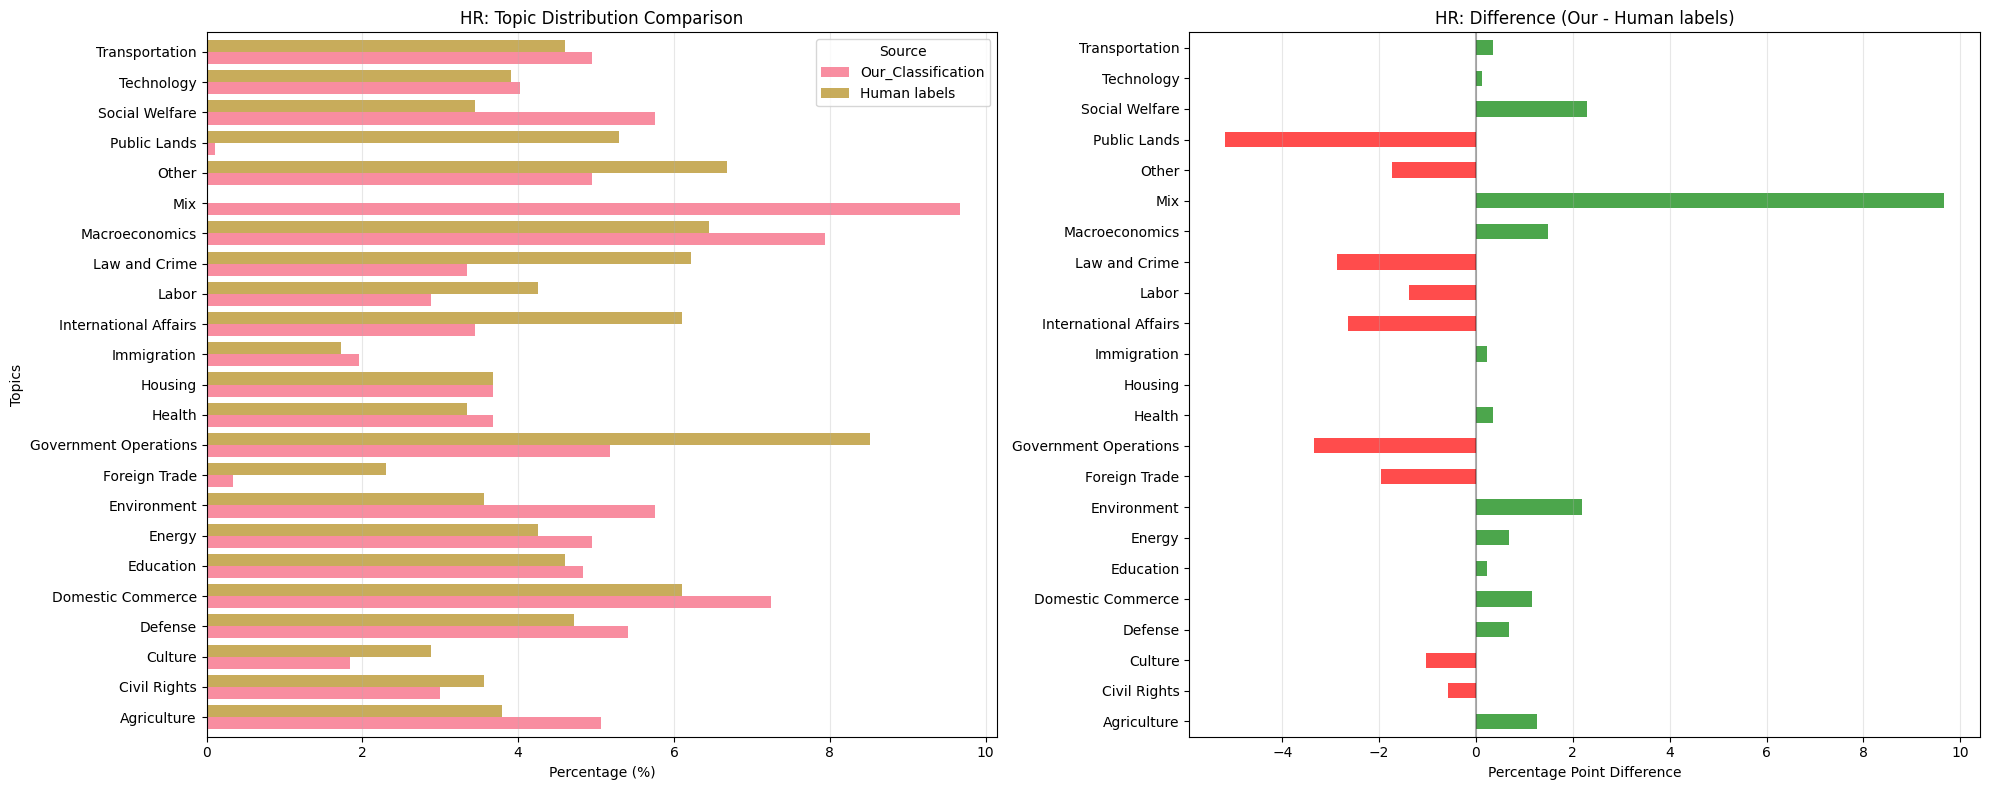


📈 HR - Largest Distribution Differences:


In [105]:
compare_topic_distributions(GB_only_true, 'topic_consensus', 'True_label', 'GB')

compare_topic_distributions(HR_only_true, 'topic_consensus', 'True_label', 'HR')

In [ ]:
# save the datasets with consensus topics
GB.to_pickle(r"data folder\GB\GB_final.pkl")
AT.to_pickle(r"data folder\AT\AT_final.pkl")
HR.to_pickle(r"data folder\HR\HR_final.pkl")